In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from xgboost import XGBRegressor
import sklearn.metrics as metrics

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\nicol\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

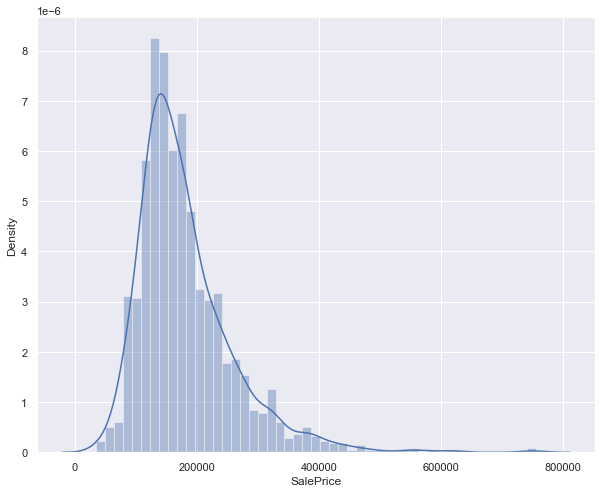

In [6]:
sns.set(rc = {'figure.figsize': (10,8)}) 
sns.distplot(train['SalePrice'])

In [7]:
print("Skewness: %f" % train['SalePrice'].skew()) # показывает скос графика относительно нормального распределения
print("Kurtosis: %f" % train['SalePrice'].kurt()) # коэффициент эксцесса показывает вытянутость вверх

Skewness: 1.882876
Kurtosis: 6.536282


C:\Users\nicol\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

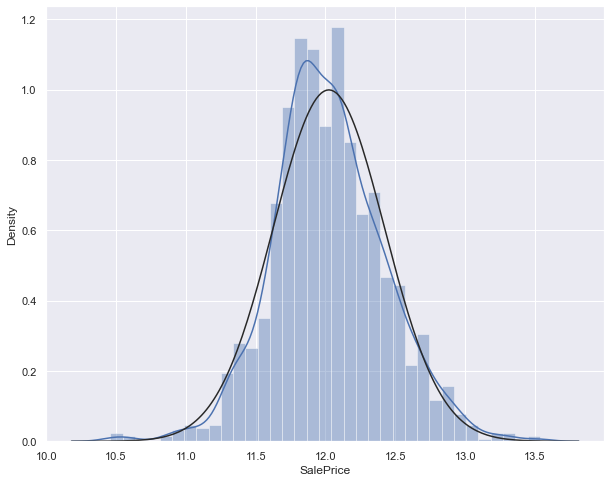

In [8]:
train['SalePrice'] = np.log1p(train['SalePrice']) #логарифмируем переменные, чтобы свести распределение к нормальному
#прибавляет 1 к элементам списка, чтобы не было неопределенности в нуле
sns.distplot(train['SalePrice'], fit=norm) #наложить нормальное распределение

Теперь все близко к нормальному распределению

In [9]:
print("Skewness: %f" % train['SalePrice'].skew()) # показывает скос графика относительно нормального распределения
print("Kurtosis: %f" % train['SalePrice'].kurt()) # коэффициент эксцесса показывает вытянутость вверх

Skewness: 0.121347
Kurtosis: 0.809519


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

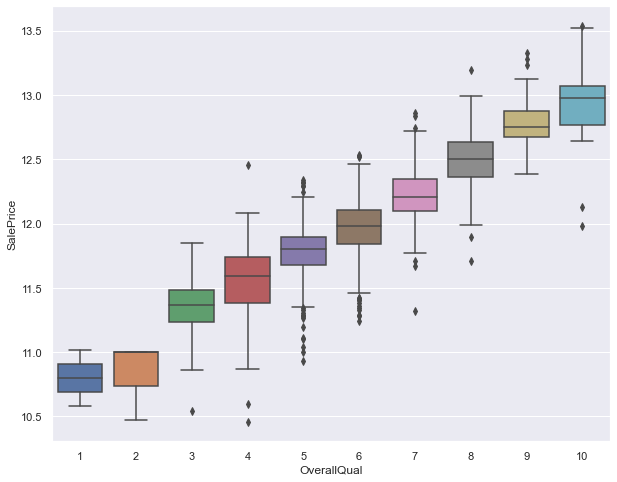

In [10]:
sns.boxplot(data=train,x='OverallQual',y='SalePrice') # прямоугольник - 1-3 квартили, усы - 1.5 межквартильных размаха 

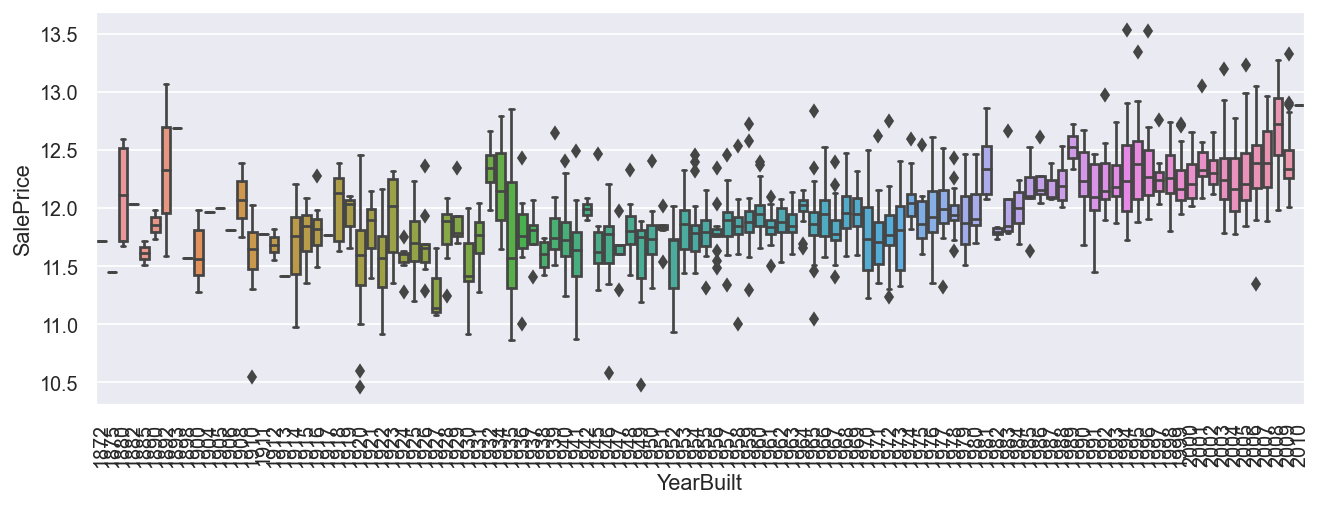

In [11]:
plt.figure(figsize=(12,4),dpi=130)
sns.boxplot(data=train,x='YearBuilt',y='SalePrice')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

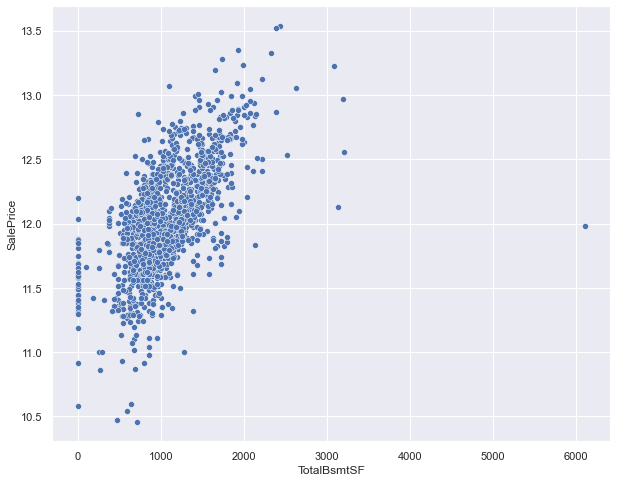

In [12]:
sns.scatterplot(data=train,x='TotalBsmtSF',y='SalePrice') #зависимость цены от площади ванной

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

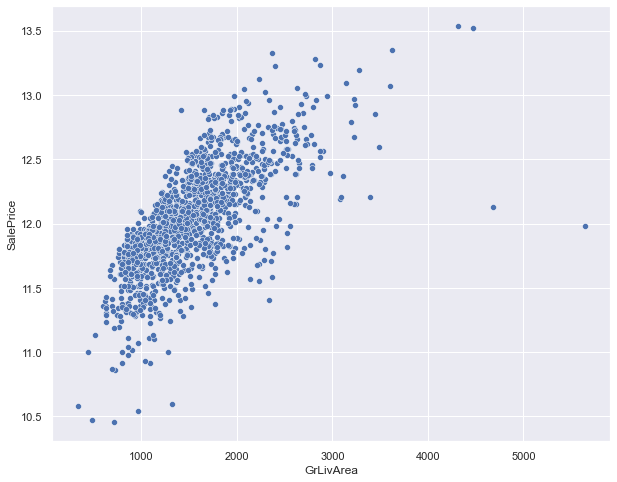

In [13]:
sns.scatterplot(data=train,x='GrLivArea',y='SalePrice')

In [14]:
train.corr()["SalePrice"].sort_values(ascending=False)[1:]

OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64

Нарисуем корреляционную матрицу тех фичей, у которых корреляция с ценой продажи больше 0.5

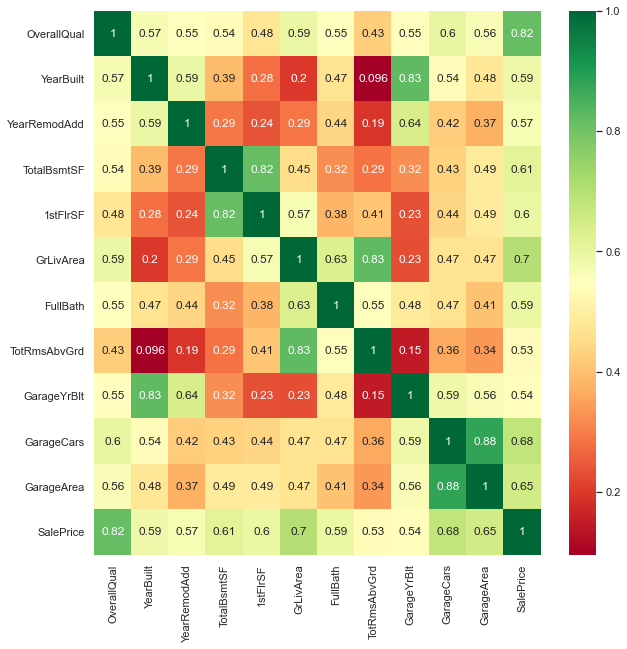

In [15]:
corr = train.corr()
highest_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

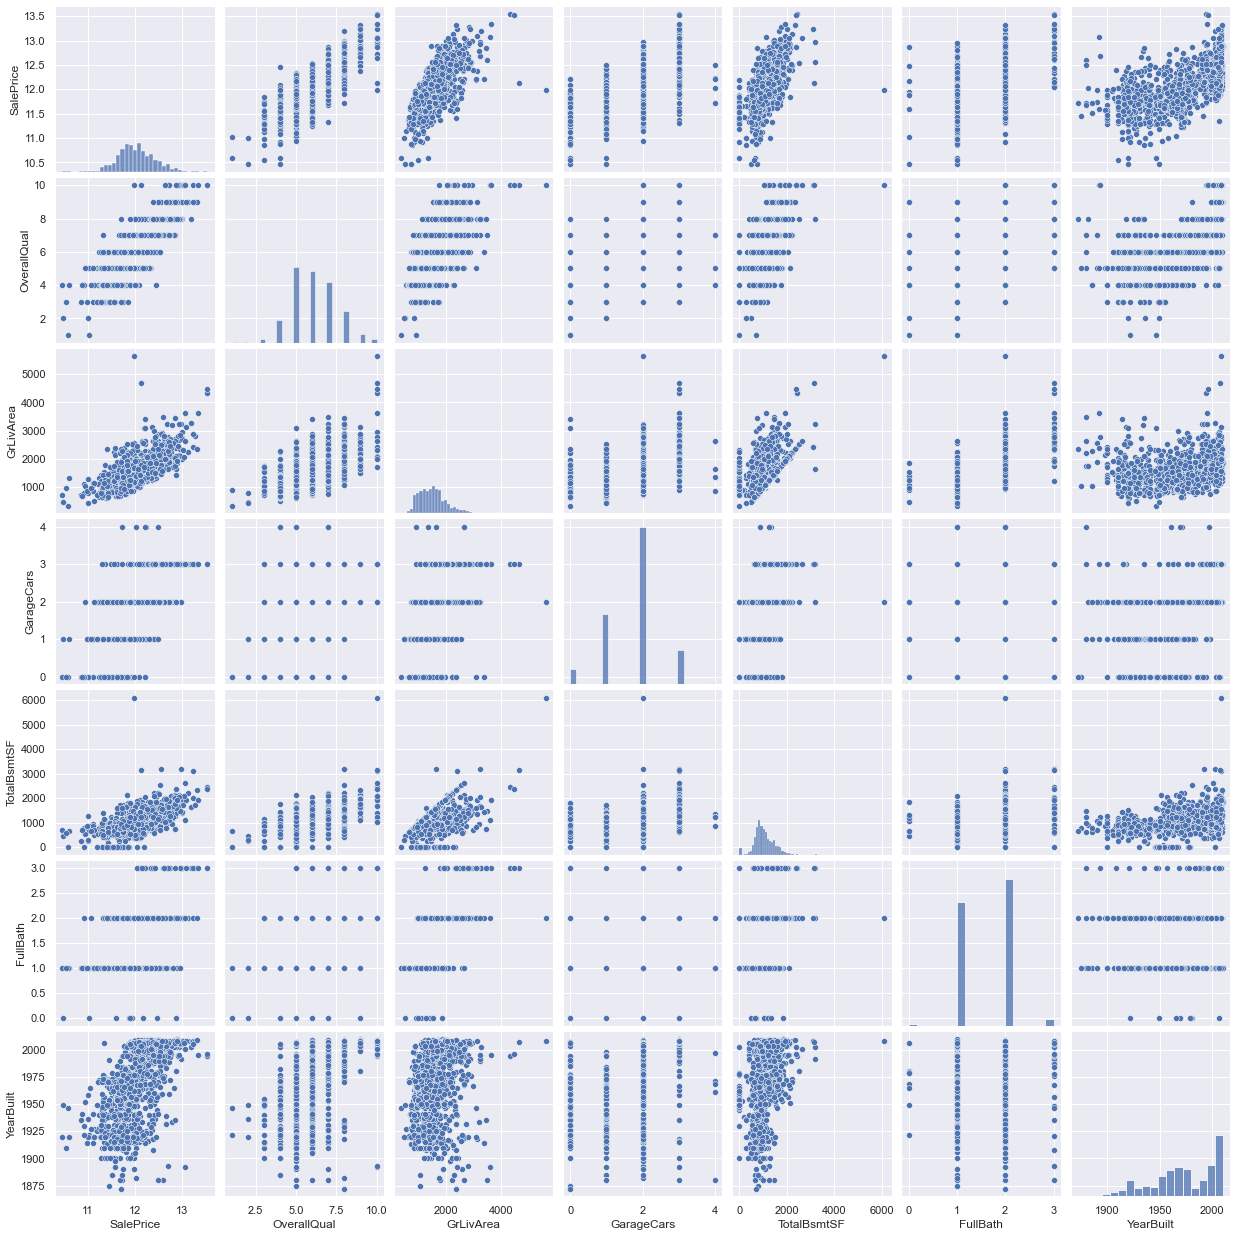

In [16]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

Для удобства объединим тренировочную и тестовую выборки в одну для предобработки

In [17]:
y_train = train['SalePrice']
test_id = test['Id']
all_data = pd.concat([train, test], axis=0, sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis=1)

In [18]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


In [19]:
all_data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True) # выкидываем значения с отсутствующими 
                                                                                         #данными, которых более 5 штук
print(all_data.isnull().sum().max())

4


In [20]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head(19)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
dtype: int64

In [21]:
# filling the numeric data
numeric_missed = ['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'GarageArea',
                  'GarageCars']

for feature in numeric_missed:
    all_data[feature] = all_data[feature].fillna(0)
#заполняем нулем, так как очень мало значений

In [22]:
categorical_missed = ['Exterior1st',
                  'Exterior2nd',
                  'SaleType',
                  'MSZoning',
                   'Electrical',
                     'KitchenQual']

for feature in categorical_missed:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0]) #заполняем модой

In [23]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [24]:
all_data.drop(['Utilities'], axis=1, inplace=True)

In [25]:
all_data.isnull().sum().max()

0

In [27]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew
# нашли скошенность распределения числовых признаков

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [28]:
for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])
# прологарифмировали, приведя к более похожему на нормальное распределению

In [29]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
# добавили новый признак из похожих

In [30]:
all_data = pd.get_dummies(all_data)
all_data.head()
# поменяли все категориальные признаки на численные

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


In [31]:
x_train =all_data[:len(y_train)]
x_test = all_data[len(y_train):]

In [32]:
x_test.shape , x_train.shape
# разбили весь датасет на тренировочный и тестовый

((1459, 219), (1460, 219))

In [33]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [37]:
scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(x_train.values) #модель, ничего не возвращает
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [52]:
import xgboost as XGB

the_model = XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
the_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4603,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0468, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1.7817, missing=nan,
             monotone_constraints='()', n_estimators=2200, n_jobs=-1,
             nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [53]:
rmse_CV_train(the_model)

array([0.10930468, 0.13747769, 0.1247417 , 0.11255765, 0.13129262])

In [54]:
y_predict = np.floor(np.expm1(the_model.predict(x_test)))
y_predict

array([124827., 158988., 187853., ..., 166523., 120375., 215407.],
      dtype=float32)

In [55]:
res = pd.DataFrame()
res['Id'] = test_id
res['SalePrice'] = y_predict
res.to_csv('result.csv',index=False)